<a href="https://colab.research.google.com/github/gve0456/Emotion-Detection-and-Music-Recommended-system/blob/main/emotion_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# emotion_recognition_fixed.ipynb
# FER2013 Dataset - Emotion Recognition with Fixed ResNet50

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Import UpSampling2D layer
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
import kagglehub
import warnings
from google.colab import drive
import shutil
import pickle
import json
from datetime import datetime

warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Download dataset using kagglehub
print("Downloading FER2013 dataset...")
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

# Define Google Drive save path
drive_save_path = "/content/drive/MyDrive/1IHBeD76fT1z9QtQqlSdOJyAOWHzobdq9/emotion_recognition_results"

# Create directory if it doesn't exist
os.makedirs(drive_save_path, exist_ok=True)

# Load and explore the dataset
def load_fer2013(dataset_path):
    train_dir = os.path.join(dataset_path, 'train')
    test_dir = os.path.join(dataset_path, 'test')

    # Check if directories exist
    if not os.path.exists(train_dir):
        # Try alternative structure
        for root, dirs, files in os.walk(dataset_path):
            if 'train' in dirs and 'test' in dirs:
                train_dir = os.path.join(root, 'train')
                test_dir = os.path.join(root, 'test')
                break

    print(f"Train directory: {train_dir}")
    print(f"Test directory: {test_dir}")

    # Emotion classes
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    # Count images in each class
    print("\nTraining set distribution:")
    for emotion in emotions:
        emotion_path = os.path.join(train_dir, emotion)
        if os.path.exists(emotion_path):
            num_images = len(os.listdir(emotion_path))
            print(f"{emotion}: {num_images} images")

    return train_dir, test_dir, emotions

train_dir, test_dir, emotions = load_fer2013(path)

# Data Preprocessing for Basic CNN (Grayscale)
def create_grayscale_generators(train_dir, test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=False
    )

    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")

    return train_generator, val_generator, test_generator

# Data Preprocessing for ResNet50 (RGB)
def convert_to_rgb(x):
    """Convert grayscale images to RGB by repeating the channel"""
    if len(x.shape) == 3:  # Single image
        if x.shape[-1] == 1:  # Grayscale
            return np.repeat(x, 3, axis=-1)
    elif len(x.shape) == 4:  # Batch of images
        if x.shape[-1] == 1:  # Grayscale
            return np.repeat(x, 3, axis=-1)
    return x

def create_rgb_generators(train_dir, test_dir):
    """Create RGB data generators with proper grayscale to RGB conversion"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators with grayscale first
    train_gray_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_gray_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    test_gray_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=False
    )

    # Convert to RGB generators
    class RGBGenerator(tf.keras.utils.Sequence):
        def __init__(self, gray_generator):
            self.gray_generator = gray_generator
            self.samples = gray_generator.samples
            self.class_indices = gray_generator.class_indices
            self.classes = gray_generator.classes
            self.batch_size = gray_generator.batch_size

        def __len__(self):
            return len(self.gray_generator)

        def __getitem__(self, index):
            x_batch, y_batch = self.gray_generator[index]
            x_batch_rgb = convert_to_rgb(x_batch)
            return x_batch_rgb, y_batch

    train_rgb_gen = RGBGenerator(train_gray_gen)
    val_rgb_gen = RGBGenerator(val_gray_gen)
    test_rgb_gen = RGBGenerator(test_gray_gen)

    print(f"RGB Training samples: {train_rgb_gen.samples}")
    print(f"RGB Validation samples: {val_rgb_gen.samples}")
    print(f"RGB Test samples: {test_rgb_gen.samples}")


    return train_rgb_gen, val_rgb_gen, test_rgb_gen

# Create generators
print("Creating grayscale generators for Basic CNN...")
train_gray_gen, val_gray_gen, test_gray_gen = create_grayscale_generators(train_dir, test_dir)

print("\nCreating RGB generators for ResNet50...")
train_rgb_gen, val_rgb_gen, test_rgb_gen = create_rgb_generators(train_dir, test_dir)

# Basic CNN Model
def create_basic_cnn():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
    ])

    return model

# --- CORRECTED ResNet50 Model ---
def create_resnet50():
    # Define the input layer for the original image size
    inputs = keras.Input(shape=(48, 48, 3))

    # Upsample the images to a size ResNet50 can handle better (e.g., 192x192)
    # 48 * 4 = 192. We use 'bilinear' interpolation.
    upsampled_inputs = UpSampling2D(size=(4, 4), interpolation='bilinear')(inputs)

    # Load ResNet50 with pre-trained weights, without the top classification layer
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(192, 192, 3) # Use the new upsampled shape here
    )

    # Freeze the layers of the base model so we only train the top layers
    base_model.trainable = False

    # Pass the upsampled inputs through the base model
    x = base_model(upsampled_inputs, training=False)

    # Add custom top layers for our classification task
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(7, activation='softmax')(x)

    # Create the final model using the Functional API
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Function to save results to Google Drive
def save_results_to_drive(model, history, model_name, test_accuracy, drive_path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_path = os.path.join(drive_path, f"{model_name}_{timestamp}")
    os.makedirs(model_save_path, exist_ok=True)

    model.save(os.path.join(model_save_path, f"{model_name}_model.h5"))

    with open(os.path.join(model_save_path, 'training_history.pkl'), 'wb') as f:
        pickle.dump(history.history, f)

    with open(os.path.join(model_save_path, 'model_summary.txt'), 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))

    results = {
        'model_name': model_name,
        'test_accuracy': test_accuracy,
        'timestamp': timestamp,
        'total_epochs': len(history.history['accuracy']),
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_val_accuracy': history.history['val_accuracy'][-1]
    }

    with open(os.path.join(model_save_path, 'results_summary.json'), 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to: {model_save_path}")
    return model_save_path

# Compile and train function
def compile_and_train(model, model_name, train_gen, val_gen, test_gen, epochs=50):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7
        )
    ]

    print(f"\n--- Training {model_name} ---")
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
    print(f"\n{model_name} Test Accuracy: {test_accuracy:.4f}")

    save_path = save_results_to_drive(model, history, model_name, test_accuracy, drive_save_path)

    return history, model, test_accuracy

# --- MODEL TRAINING ---

# 1. Train Basic CNN
print("\n=== STARTING BASIC CNN TRAINING ===")
basic_cnn_model = create_basic_cnn()
basic_cnn_history, trained_basic_cnn, basic_cnn_accuracy = compile_and_train(
    basic_cnn_model, "Basic_CNN", train_gray_gen, val_gray_gen, test_gray_gen
)

# 2. Train Fixed ResNet50
print("\n=== STARTING FIXED RESNET50 TRAINING ===")
resnet50_model = create_resnet50()
resnet50_history, trained_resnet50, resnet50_accuracy = compile_and_train(
    resnet50_model, "Fixed_ResNet50", train_rgb_gen, val_rgb_gen, test_rgb_gen
)

print("\n--- All training complete. ---")

Mounted at /content/drive
Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013
Train directory: /kaggle/input/fer2013/train
Test directory: /kaggle/input/fer2013/test

Training set distribution:
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
neutral: 4965 images
sad: 4830 images
surprise: 3171 images
Creating grayscale generators for Basic CNN...
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Training samples: 22968
Validation samples: 5741
Test samples: 7178

Creating RGB generators for ResNet50...
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
RGB Training samples: 22968
RGB Validation samples: 5741
RGB Test samples: 7178

=== STARTING BASIC CNN TRAINING ===

--- Training Basic_CNN ---
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 174s 443ms/step - ac


Basic_CNN Test Accuracy: 0.6284


Results saved to: /content/drive/MyDrive/1IHBeD76fT1z9QtQqlSdOJyAOWHzobdq9/emotion_recognition_results/Basic_CNN_20251006_122454

=== STARTING FIXED RESNET50 TRAINING ===
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

--- Training Fixed_ResNet50 ---
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.1947 - loss: 2.5208 - val_accuracy: 0.2515 - val_loss: 1.8102 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.2371 - loss: 1.9507 - val_accuracy: 0.2719 - val_loss: 1.7599 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.2541 - loss: 1.8220 - val_accuracy: 0.2780 - val_loss: 1.7739 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.2638 - loss: 1.7961 - val_accuracy: 0.2735 - val_loss: 1.7562 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.2715 - loss: 1.7827 - val_accuracy: 0.2834 - val_loss: 1


Fixed_ResNet50 Test Accuracy: 0.3420


Results saved to: /content/drive/MyDrive/1IHBeD76fT1z9QtQqlSdOJyAOWHzobdq9/emotion_recognition_results/Fixed_ResNet50_20251006_130701

--- All training complete. ---


In [ ]:
# 2. Train Fixed ResNet50
print("\n=== STARTING FIXED RESNET50 TRAINING ===")
resnet50_model = create_resnet50()
resnet50_history, trained_resnet50, resnet50_accuracy = compile_and_train(
    resnet50_model, "Fixed_ResNet50", train_rgb_gen, val_rgb_gen, test_rgb_gen
)


=== STARTING FIXED RESNET50 TRAINING ===

--- Training Fixed_ResNet50 ---
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.1924 - loss: 2.4751 - val_accuracy: 0.2592 - val_loss: 1.8047 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 139ms/step - accuracy: 0.2359 - loss: 1.9416 - val_accuracy: 0.2689 - val_loss: 1.7628 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.2615 - loss: 1.8294 - val_accuracy: 0.2811 - val_loss: 1.7592 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.2640 - loss: 1.7953 - val_accuracy: 0.2797 - val_loss: 1.7583 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - accuracy: 0.2658 - loss: 1.7895 - val_accuracy: 0.2885 - val_loss: 1.7506 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 144ms/step - accuracy: 0.2727 - loss: 1.7787 - val_accuracy: 0.2728 - val_loss: 1.7555 - learning_rate: 0.


Fixed_ResNet50 Test Accuracy: 0.3363


Results saved to: /content/drive/MyDrive/1IHBeD76fT1z9QtQqlSdOJyAOWHzobdq9/emotion_recognition_results/Fixed_ResNet50_20251006_135100



--- Plotting Basic CNN Training History ---


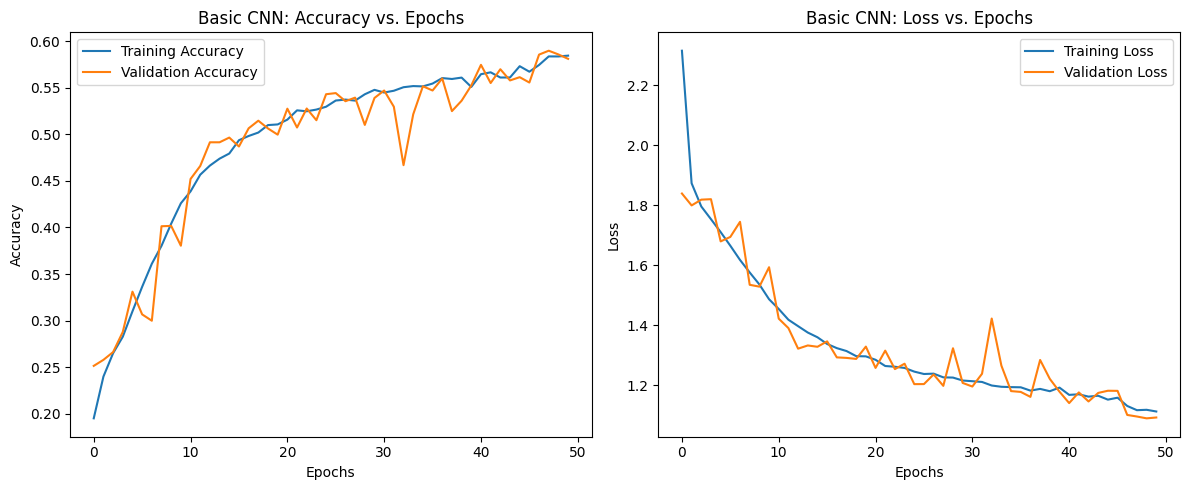


--- Evaluating Basic CNN on Test Set ---
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step

Classification Report (Basic CNN):
              precision    recall  f1-score   support

       angry       0.52      0.61      0.56       958
     disgust       0.54      0.17      0.26       111
        fear       0.51      0.26      0.35      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.54      0.71      0.61      1233
         sad       0.50      0.49      0.49      1247
    surprise       0.74      0.76      0.75       831

    accuracy                           0.63      7178
   macro avg       0.60      0.55      0.55      7178
weighted avg       0.63      0.63      0.62      7178


Confusion Matrix (Basic CNN):


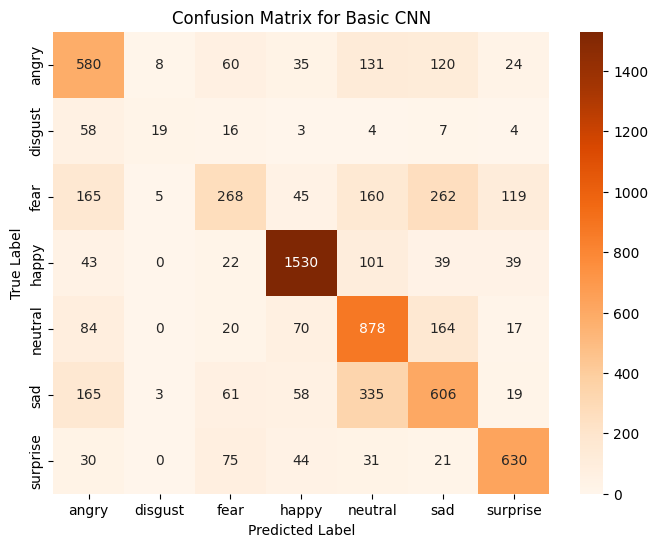

In [ ]:
# --- START: ANALYSIS FOR BASIC CNN MODEL ---

# Plot the training history for the Basic CNN model
print("\n--- Plotting Basic CNN Training History ---")
history_df_cnn = pd.DataFrame(basic_cnn_history.history)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df_cnn['accuracy'], label='Training Accuracy')
plt.plot(history_df_cnn['val_accuracy'], label='Validation Accuracy')
plt.title('Basic CNN: Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_df_cnn['loss'], label='Training Loss')
plt.plot(history_df_cnn['val_loss'], label='Validation Loss')
plt.title('Basic CNN: Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Get predictions on the test set for the Basic CNN
print("\n--- Evaluating Basic CNN on Test Set ---")
# Use the grayscale generator since the CNN was trained on it
y_pred_prob_cnn = trained_basic_cnn.predict(test_gray_gen)
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

# Get true labels and class names
y_true_cnn = test_gray_gen.classes
class_names_cnn = list(test_gray_gen.class_indices.keys())

# 1. Classification Report for Basic CNN
print("\nClassification Report (Basic CNN):")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names_cnn))

# 2. Confusion Matrix for Basic CNN
print("\nConfusion Matrix (Basic CNN):")
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names_cnn, yticklabels=class_names_cnn)
plt.title('Confusion Matrix for Basic CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- END: ANALYSIS FOR BASIC CNN MODEL ---


--- Evaluating ResNet50 on Test Set ---
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.28      0.05      0.08       958
     disgust       0.00      0.00      0.00       111
        fear       0.22      0.07      0.10      1024
       happy       0.35      0.75      0.47      1774
     neutral       0.36      0.29      0.32      1233
         sad       0.31      0.07      0.12      1247
    surprise       0.34      0.64      0.44       831

    accuracy                           0.34      7178
   macro avg       0.26      0.27      0.22      7178
weighted avg       0.31      0.34      0.27      7178


Confusion Matrix:


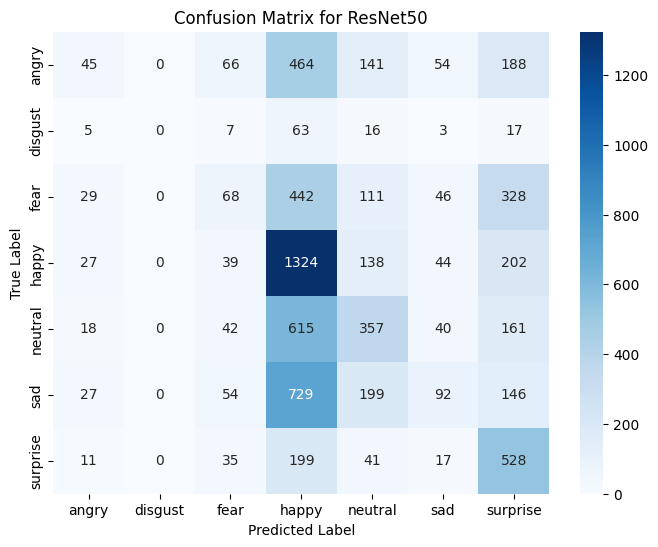


--- All training and analysis complete. ---


In [ ]:
# Get predictions on the test set
print("\n--- Evaluating ResNet50 on Test Set ---")
y_pred_prob = trained_resnet50.predict(test_rgb_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_rgb_gen.gray_generator.classes
class_names = list(test_rgb_gen.class_indices.keys())

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


# 2. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- All training and analysis complete. ---")


--- Plotting Fixed ResNet50 Training History ---


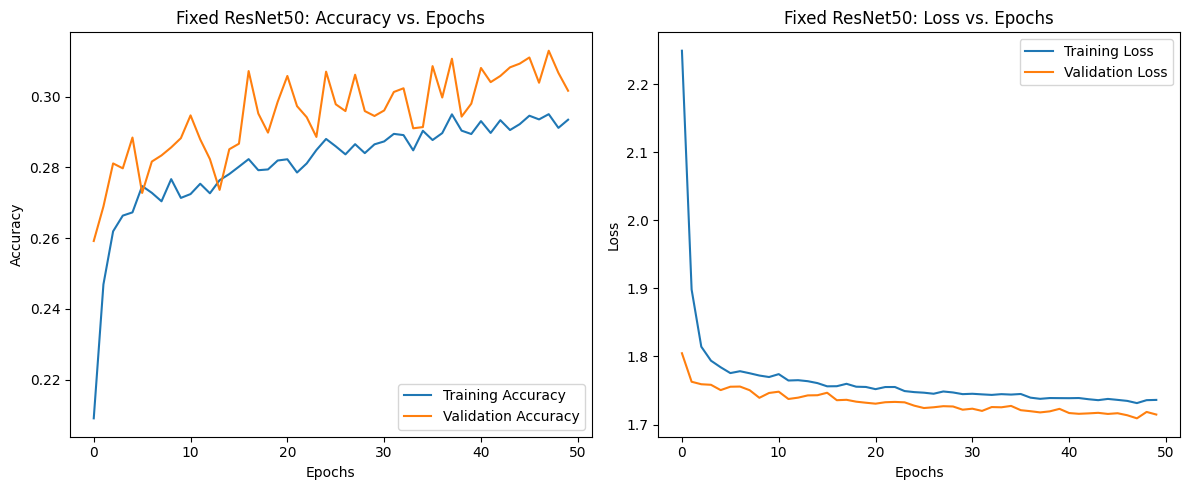

In [ ]:
# --- START: ANALYSIS FOR Fixed ResNet50 MODEL ---

# Plot the training history for the Fixed ResNet50 model
print("\n--- Plotting Fixed ResNet50 Training History ---")
# Access the history from the trained_resnet50 variable if it's available,
# otherwise use resnet50_history if the training function returned it.
# Assuming compile_and_train returns history in resnet50_history:
history_df_resnet = pd.DataFrame(resnet50_history.history)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df_resnet['accuracy'], label='Training Accuracy')
plt.plot(history_df_resnet['val_accuracy'], label='Validation Accuracy')
plt.title('Fixed ResNet50: Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_df_resnet['loss'], label='Training Loss')
plt.plot(history_df_resnet['val_loss'], label='Validation Loss')
plt.title('Fixed ResNet50: Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- END: ANALYSIS FOR Fixed ResNet50 MODEL ---